In [1]:
#对于低噪或不含噪数据 请运行本小节代码
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from datetime import datetime
import nfode
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint as odeint

device = torch.device('cpu')

data = np.load('data_set.npz')
t_data = data['t_data']
x_data = data['x_data']

# Define the moving average function
def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')


window_size = 10  # Adjust window size as needed
#x_data = np.array([moving_average(row, window_size) for row in x_data])

# 主程序
lr = 0.01
#model = nfode.ODEModel()
#nfode.initialize_params_uniform(model)
model = torch.load('neuralode_model.pt')
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1, last_epoch=-1)
loss_fn = nn.MSELoss()
loss_curve = []
i = 0
while i < 60:
    optimizer.zero_grad()
    #i=np.random.randint(0, 60)
    x_tensor = torch.tensor(x_data[:,:,i], dtype=torch.float32).requires_grad_(True).to(device)
    t_tensor = torch.tensor(t_data[i,:], dtype=torch.float32).requires_grad_(True).to(device)
    x_preds = odeint(model, x_tensor[:, 0], t_tensor, atol=1e-4, rtol=1e-4)
    loss = loss_fn(x_preds, x_tensor.T)
    loss.backward(retain_graph=False)
    loss_curve.append(loss.item())
    optimizer.step()
    scheduler.step()
    if loss.item() <= 0.05:
        i += 1
    print(i, loss.item())


0 0.20973528921604156
0 0.2526702284812927
0 0.1824294477701187
0 0.06902096420526505
0 0.14945028722286224
0 0.12533630430698395
0 0.06375681608915329
1 0.049204252660274506
1 0.2796151638031006
1 0.14114272594451904
1 0.17233657836914062
1 0.20261891186237335
1 0.09371510148048401
1 0.055169448256492615
1 0.1294395625591278
1 0.09315662831068039
1 0.06369201093912125
1 0.0862763449549675
1 0.09968749433755875
1 0.0717305988073349
2 0.037531543523073196
2 0.40612006187438965
2 0.18738146126270294
2 0.16201375424861908
2 0.2617793083190918
2 0.16897602379322052
2 0.05854136869311333
2 0.11839400976896286
2 0.16237206757068634
2 0.09867045283317566
2 0.05987505242228508
2 0.08614921569824219
2 0.09004475176334381
3 0.04085161164402962
3 0.19655780494213104
3 0.1046282947063446
3 0.07421766221523285
3 0.13689297437667847
3 0.12098869681358337
3 0.058272585272789
3 0.05518186464905739
3 0.07043076306581497
3 0.05660763382911682
4 0.03815249353647232
4 0.09249527752399445
4 0.0861052200198

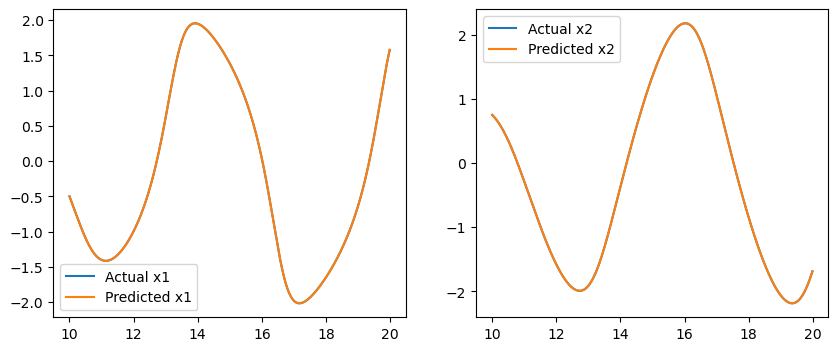

In [12]:
def vdpo(x, m=1):
    dx1 = m*(x[0] - 1/3*x[0]**3 -x[1])
    dx2 = 1/m*x[0]
    return np.array([dx1, dx2])

def euler_step(model, dt, x_last, m=1):
    dx = model(x_last)
    x_next = x_last + dx * dt
    return x_next

def generate_data(model, x10, x20, start_time_point=0, end_time_point=10, dt = 0.01):
    num_points = int((end_time_point-start_time_point)/dt)
    t = np.arange(start_time_point, end_time_point, dt)
    x = np.zeros((2, num_points))
    x[:, 0] = [x10, x20]
    for i in range(1, num_points):
        x_last = x[:, i-1]
        ti = t[i-1]
        dt = t[i] - t[i-1]
        x_new = euler_step(model, dt, x_last)
        x[:, i] = x_new
    return t, x

data = generate_data(vdpo, -0.5, 0.75, start_time_point=10, end_time_point=20)
t_data, x_data = data
t_tensor = torch.tensor(t_data, dtype=torch.float32)
x_tensor = torch.tensor(x_data, dtype=torch.float32)
x_preds = odeint(model, x_tensor[:,0], t_tensor)
x_preds = x_preds.detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(t_data, x_data[0, :], label='Actual x1')
ax[0].plot(t_data, x_data[0, :], label='Predicted x1')

ax[1].plot(t_data, x_data[1, :], label='Actual x2')
ax[1].plot(t_data, x_data[1, :], label='Predicted x2')

ax[0].legend()
ax[1].legend()

In [3]:
torch.save(model, 'neuralode_model.pt')